# Introduction

In this notebook, we explore the **Electric consumption data** we were provided in the context of our challenge. 

The main challenge is to "de-noise" aggregated consumption data to isolate electronic equipments. 

For each time step, we know overall consumption and various weather data **features** : 
- visibility
- temperature
- humidity
- humidex
- windchill
- wind
- pressure

The **target** is the timestep consumption for each of the following appliances: 
- washing machine
- fridge freezer
- TV
- kettle 

We evaluate model performance based on a **custom metric**, which you will find below: 


```
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = np.array(dataframe_y_true['washing_machine'])
    pred = np.array(dataframe_y_pred['washing_machine'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = np.array(dataframe_y_true['fridge_freezer'])
    pred = np.array(dataframe_y_pred['fridge_freezer'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = np.array(dataframe_y_true['TV'])
    pred = np.array(dataframe_y_pred['TV'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = np.array(dataframe_y_true['kettle'])
    pred = np.array(dataframe_y_pred['kettle'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score
```
The notebook comprises four parts: 
- Data Loading and Exploration
- Data pre-processing and Feature Engineering
- Base model fit
- Prediction generation


In [ ]:
#@title Link the notebook to your drive. 
from google.colab import files

In [ ]:
#@title Run all useful imports.
import pandas as pd
pd.options.display.max_rows = 999
import math as mt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time
import holidays
import pickle
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...


from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
pd.set_option('max_rows', 100)

In [ ]:
#@title Define all functions you will use 
def initialisation(df):
  df["time_step"] = pd.to_datetime(df["time_step"])
  # Segmenting periods
  df["month"] = df.apply(lambda x: x["time_step"].month, axis=1)
  df["day"] = df.apply(lambda x: x["time_step"].day, axis=1)
  df["hour"] = df.apply(lambda x: x["time_step"].hour, axis=1)

  # Minuted could be especially valuable
  df["minute"] = df.apply(lambda x: x["time_step"].minute, axis=1)
  df = df.drop(columns={"Unnamed: 9"})
  df.head()
  return df 

def fill_weather(data):
  data_minute_0 = data[data["minute"]==0]
  ###
  # Identifying the NaNs we have to fix
  humidity_nans = data_minute_0[data_minute_0["humidity"].isna()]
  humidex_nans  = data_minute_0[data_minute_0["humidex"].isna()]
  windchill_nans  = data_minute_0[data_minute_0["windchill"].isna()]
  wind_nans  = data_minute_0[data_minute_0["wind"].isna()]
  visibility_nans  = data_minute_0[data_minute_0["visibility"].isna()]
  pressure_nans  = data_minute_0[data_minute_0["pressure"].isna()] 
  temperature_nans  = data_minute_0[data_minute_0["temperature"].isna()] 
  # Introducing a table with the mean of each weather variable within a given month
  monthly_weather = data.groupby("month").mean().loc[:,"consumption":"pressure"].reset_index()


  # Filling the nans using monthly mean for minute 0 by mapping dictionaries within a loop
  weather_nans = [humidity_nans, humidex_nans, windchill_nans, wind_nans, visibility_nans, pressure_nans, temperature_nans]
  weather_columns = ["humidity", "humidex", "windchill", "wind", "visibility", "pressure", "temperature"]
  keys = monthly_weather["month"].tolist() # need to pass keys and values to list to make a dictionary
  for i in np.arange(len(weather_nans)):
    values = monthly_weather[weather_columns[i]].tolist()
    my_dict = dict(zip(keys, values))
    weather_nans[i][weather_columns[i]] = weather_nans[i]["month"].map(my_dict)
    data_minute_0[weather_columns[i]][data_minute_0[weather_columns[i]].isna()] = weather_nans[i][weather_columns[i]]
  
  data[data["minute"]==0] = data_minute_0
  ###

  ###
  # Taking care of minute 1 for the first month given that there is no minute 0 
  if np.isnan(data.iloc[0,1]):
    data.iloc[0,1:8] = monthly_weather.iloc[0,1:9]
  
  # Creating a weather dataframe for forward fill
  data_weather = data.loc[:,"visibility":"pressure"]
  data_weather = data_weather.fillna(method='ffill')
  # Finally replacing the incomplete weather data by our filled table 
  data.loc[:,"visibility":"pressure"] = data_weather
  
  ###

  ###
  # Creating a daytime feature
  day_boundaries = [7,20] # defining daytime hours, could segment more precisely 
  data["daytime"] = data.apply(lambda x: (x["hour"]in range(day_boundaries[0],day_boundaries[1]))*1, axis=1)
  ###
  return data

def forward_fill_consumption(data):
  data['consumption'] = data['consumption'].fillna(method='ffill')
  #data['washing_machine'] = data['washing_machine'].fillna(method='ffill')
  #data['fridge_freezer'] = data['fridge_freezer'].fillna(method='ffill')
  #ata['TV'] = data['TV'].fillna(method='ffill')
  #data['kettle'] = data['kettle'].fillna(method='ffill')
  return data

def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = np.array(dataframe_y_true['washing_machine'])
    pred = np.array(dataframe_y_pred['washing_machine'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = np.array(dataframe_y_true['fridge_freezer'])
    pred = np.array(dataframe_y_pred['fridge_freezer'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = np.array(dataframe_y_true['TV'])
    pred = np.array(dataframe_y_pred['TV'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = np.array(dataframe_y_true['kettle'])
    pred = np.array(dataframe_y_pred['kettle'])
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score


def create_y_predictions(x_out, best_model):
  Y_test_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_test_temp)
  Y_test = pd.DataFrame(x_out_temp["time_step"])
  Y_test["washing_machine"] = df.iloc[:,0]
  Y_test["fridge_freezer"] = df.iloc[:,1]
  Y_test["TV"] = df.iloc[:,2]
  Y_test["kettle"] = df.iloc[:,3]
  Y_test.to_csv('y_test_no_activation.csv', header=True)
  print(Y_test)
  files.download("y_test_no_activation_500est.csv")
  return Y_test

In [ ]:
# Data links
url_xtrain = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/inputs/X_train_6GWGSxz.csv"
url_xout = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/inputs/X_test_c2uBt2s.csv"
url_ytrain = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/inputs/y_train_2G60rOL.csv"

# Data Loading and Exploration.

In [ ]:
# Importing our data
X_train = pd.read_csv(url_xtrain)
X_out = pd.read_csv(url_xout)
y_train = pd.read_csv(url_ytrain)

Let's visualise our training data : 

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
print(X_train.shape, y_train.shape)

We have the data for 416,599 timesteps.

Our objective is to predict an array of electronic equipment consumptions based on overall consumption for our home and weather indications, to implement "non-intrusive" monitoring methods.  
We aim to predict a fraction of electric consumption by appliance. 

In [ ]:
X_train.describe()

In [ ]:
y_train.describe()

Let us check for missing values : 

In [ ]:
X_train.isna().sum()

There is a high number of missing values : weather data seems to be missing for the full dataset.  
All variables except consumption and unnamed seem to have approxiately the same number of missing values, potentially indicating a pattern in the missing data.

Let us create the training dataframe :

In [ ]:
# Creating a training dataframe for data exploration
df = pd.concat([X_train,y_train],axis=1,sort=False)
df = df.loc[:,"consumption":"kettle"]
df = df.drop(columns="Unnamed: 9")
df.head()

Let's standardise the timesteps.

In [85]:
# Datetime pre-processing
df["time_step"] = pd.to_datetime(df["time_step"])

# Time features
df["month"] = df.apply(lambda x: x["time_step"].month, axis=1)
df["day"] = df.apply(lambda x: x["time_step"].day, axis=1)
df["hour"] = df.apply(lambda x: x["time_step"].hour, axis=1)
df["day_of_week"] = df["time_step"].dt.weekday
df["minute"] = df.apply(lambda x: x["time_step"].minute, axis=1)
df.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute
0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1
1,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2
2,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3
3,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4
4,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5


Let's plot a few histograms corresponding to our training features.

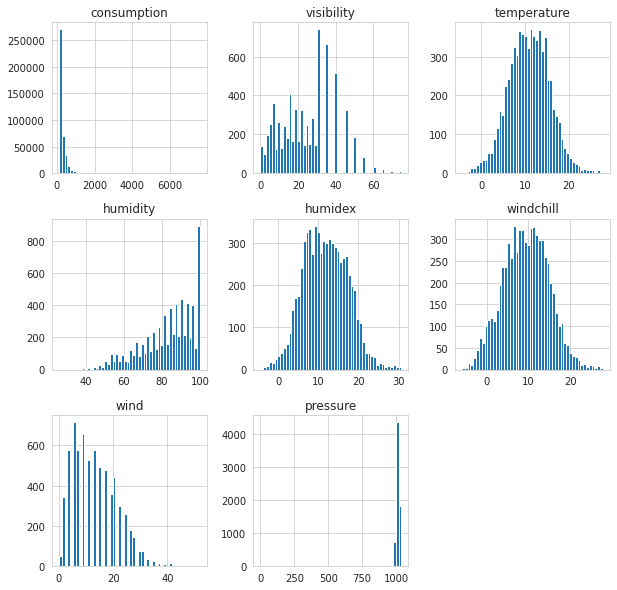

In [86]:
X_train.drop(columns=["Unnamed: 9"]).hist(bins=50, figsize=(10,10))
plt.title("Feature distributions.")
plt.show()

Temperature, humidex and windchill seem to have normal distributions. 
If we find no better way, we could use simulations of normal distributions with same mean and variance to fill in their missing values. 

11.75 5.47


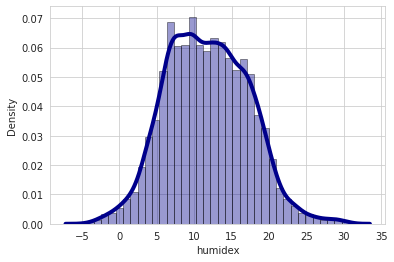

In [87]:
print("%.2f"%np.nanmean(df["humidex"]), "%.2f"%np.nanstd(df["humidex"]))
sns_plot = sns.distplot(df.loc[:,"humidex"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

10.86 4.68


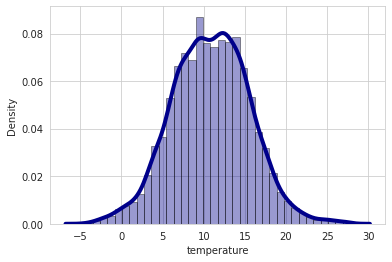

In [88]:
print("%.2f"%np.nanmean(df["temperature"]), "%.2f"%np.nanstd(df["temperature"]))
sns_plot = sns.distplot(df.loc[:,"temperature"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

9.33 5.42


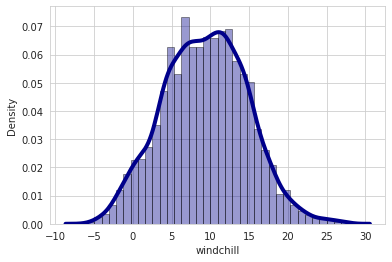

In [89]:
print("%.2f"%np.nanmean(df["windchill"]), "%.2f"%np.nanstd(df["windchill"]))
sns_plot = sns.distplot(df.loc[:,"windchill"], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig = sns_plot.get_figure()

Let's visualise our targets : 

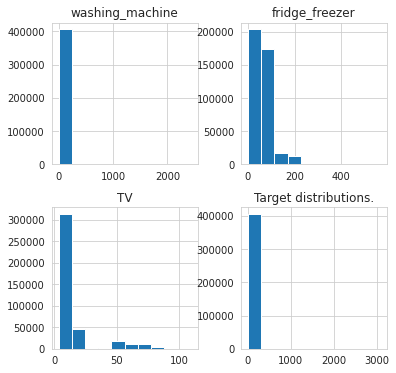

In [90]:
df.loc[:,"washing_machine":"kettle"].hist(figsize=(6,6))
plt.title("Target distributions.")
plt.show()

Let's investigate our targets individually.

This is what we get for consumption : 

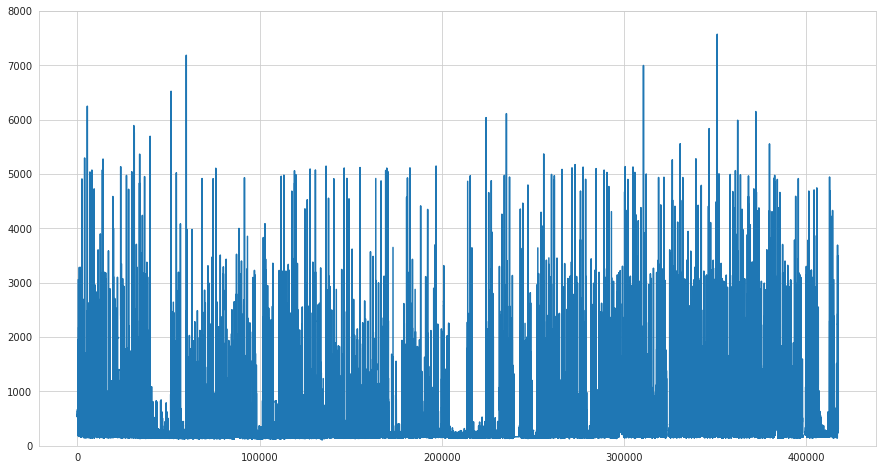

In [91]:
df["consumption"].plot(figsize=(15,8))
plt.ylim(0, 8000) 
plt.show()

Overall consumption presents peak and creases over the year, possible corresponding to the house's occupancy pattern. We then have a look into individual appliance consumption, on a power scale from 0 to 3000 to make their consumption comparable.

Next, let's have a look at washing machine specifically. Washing machine is the most important target to predict, given its weight in the custom metric.

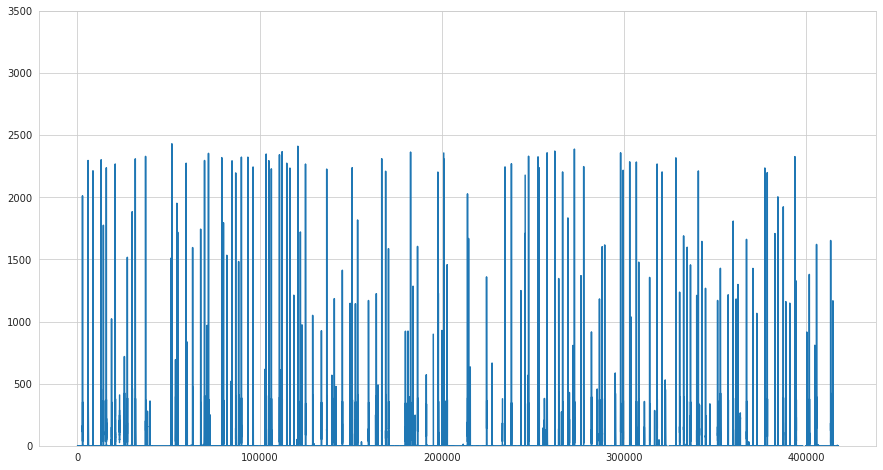

In [92]:
df["washing_machine"].plot(figsize=(15,8))
plt.ylim(0, 3500) 
plt.show()

Kettle presents high irregularities and consumes a lot of electricity when it is turned on : 

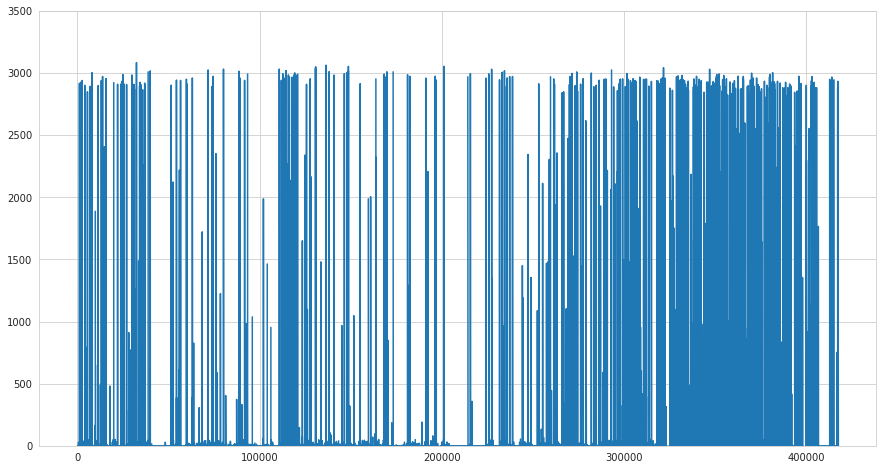

In [93]:
df["kettle"].plot(figsize=(15,8))
plt.ylim(0, 3500) 
plt.show()

Fridge freezer consumes much less than the washing machine, but is pretty constant throughout the year: 

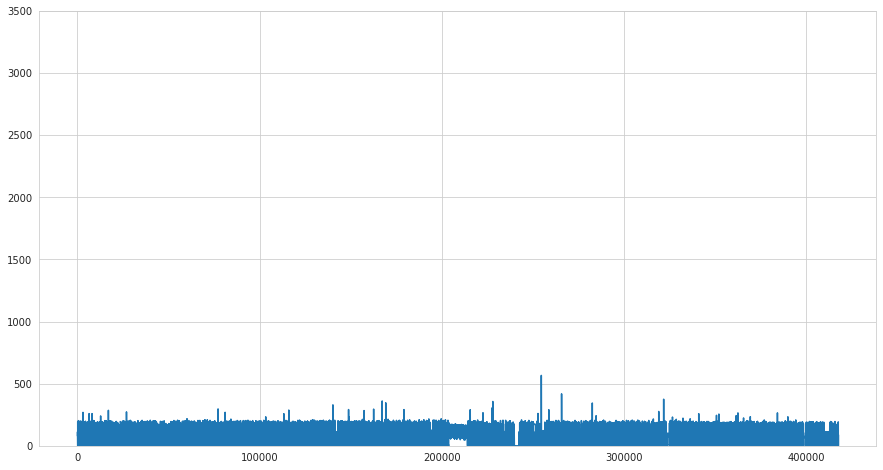

In [94]:
df["fridge_freezer"].plot(figsize=(15,8))
plt.ylim(0, 3500) 
plt.show()

TV represents an even lower consumption, but presents a strong timestep pattern. 

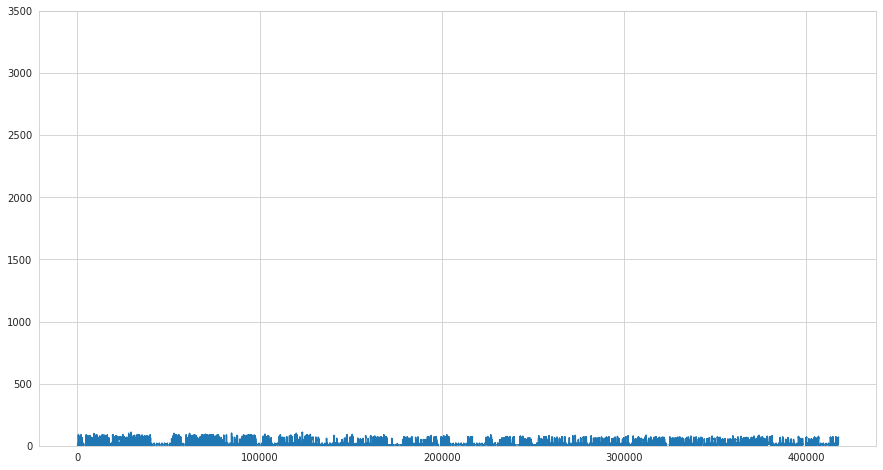

In [95]:
df["TV"].plot(figsize=(15,8))
plt.ylim(0, 3500) 
plt.show()

Now let's have a look at all targets together to confirm our intuition : 

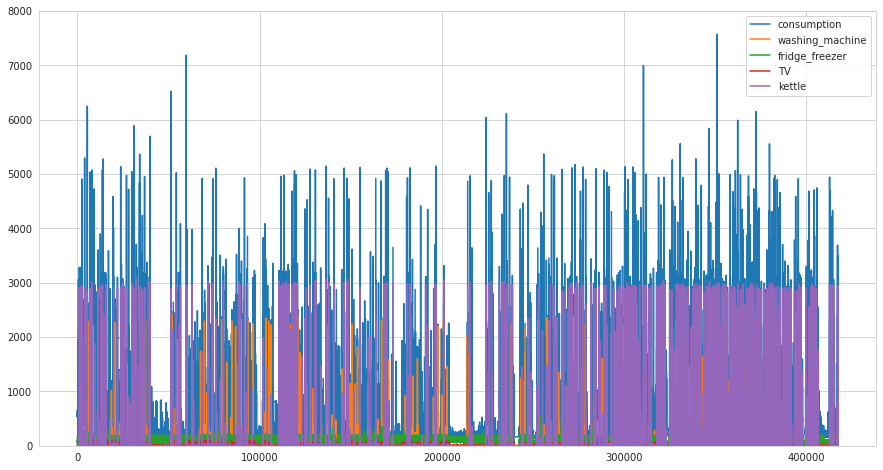

In [96]:
features = ["consumption", "washing_machine", "fridge_freezer", "TV", "kettle"]
df.loc[:,features].plot(figsize=(15,8))
plt.ylim(0, 8000) 
plt.show()

Next, we investigate correlations.

In [97]:
# Dropping unnamed since the NaNs created errors in the correlation matrix
corr_matrix = df.corr()
corr_matrix.style.background_gradient(cmap='BuPu').set_precision(2)

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute
consumption,1.00,0.03,-0.06,0.00,-0.06,-0.06,0.02,-0.07,0.21,0.12,0.18,0.39,0.07,0.00,0.15,0.01,-0.00
visibility,0.03,1.00,0.02,-0.46,-0.03,-0.02,0.16,-0.02,-0.01,-0.01,0.01,0.01,-0.01,-0.04,0.12,0.01,nan
temperature,-0.06,0.02,1.00,-0.51,0.99,0.98,0.08,0.04,0.00,0.07,-0.02,-0.01,-0.24,0.01,0.25,-0.03,nan
humidity,0.00,-0.46,-0.51,1.00,-0.42,-0.46,-0.26,-0.04,-0.01,0.00,-0.02,0.00,0.30,-0.04,-0.37,0.05,nan
humidex,-0.06,-0.03,0.99,-0.42,1.00,0.97,0.06,0.04,0.00,0.08,-0.02,-0.01,-0.21,0.01,0.23,-0.02,nan
windchill,-0.06,-0.02,0.98,-0.46,0.97,1.00,-0.10,0.06,0.00,0.07,-0.03,-0.01,-0.23,-0.00,0.22,-0.02,nan
wind,0.02,0.16,0.08,-0.26,0.06,-0.10,1.00,-0.08,-0.02,-0.01,0.02,0.00,-0.04,0.06,0.16,-0.02,nan
pressure,-0.07,-0.02,0.04,-0.04,0.04,0.06,-0.08,1.00,0.00,-0.00,-0.02,-0.03,-0.05,0.06,-0.02,-0.02,nan
washing_machine,0.21,-0.01,0.00,-0.01,0.00,0.00,-0.02,0.00,1.00,0.00,-0.01,-0.00,0.00,-0.01,0.04,0.01,0.00
fridge_freezer,0.12,-0.01,0.07,0.00,0.08,0.07,-0.01,-0.00,0.00,1.00,0.02,0.01,0.04,-0.03,0.03,-0.01,0.00


Consumption presents the highest correlations to our output {washing_machine, fridge_freezer, TV, kettle}, as one could expect.

In [98]:
corr_matrix["consumption"].sort_values(ascending=False)

consumption        1.000000
kettle             0.388482
washing_machine    0.206889
TV                 0.183381
hour               0.148759
fridge_freezer     0.119655
month              0.071201
visibility         0.028942
wind               0.018537
day_of_week        0.006900
humidity           0.001947
day                0.000871
minute            -0.000122
temperature       -0.056331
humidex           -0.061327
windchill         -0.061684
pressure          -0.068219
Name: consumption, dtype: float64

As expected, given the high values they take when they are on, kettle and washing machine are most closely related to overall consumption. Let's confirm this visually:

We place the graphs sequentially to be able to compare them by eye.  
For every graph, we observe that the high occurrence of points at 0 cause fallacious linear regression fits.  

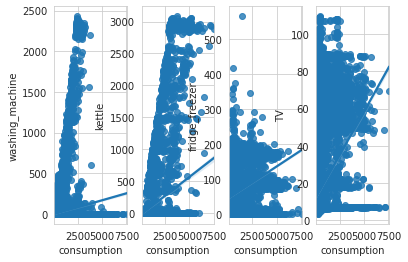

In [99]:
# Washing machine 
fig, axs = plt.subplots(ncols=4)
sns.set_style("whitegrid")
sns_plot = sns.regplot(x = "consumption",
           y = "washing_machine", 
           data = df,  
         #  legend = True, 
         #  scatter_kws={"s": 5},
           ax=axs[0])

# Kettle
sns_plot = sns.regplot(x = "consumption",
           y = "kettle", 
           data = df,  
          # legend = True, 
          # scatter_kws={"s": 5},
           ax=axs[1])

# Fridge_freezer
sns_plot = sns.regplot(x = "consumption",
           y = "fridge_freezer", 
           data = df,  
          # legend = True, 
         #  scatter_kws={"s": 5},
           ax=axs[2])


# TV
sns_plot = sns.regplot(x = "consumption",
           y = "TV", 
           data = df,  
          # legend = True, 
          # scatter_kws={"s": 5},
           ax=axs[3])

- Kettle : Again, we observe two very different cases: either kettle consumption is set to zero, either it depends linearly on consumption. 
- Fridge freezer : we observe three levels of consumption for our fridge_freezers at any total consumption over 1000W. Under 1000W, it would seem that points are equi-distributed. 
- TV : Relations between TV and overall consumption are more difficult to establish: we seem to have thresholds, once again.

 Then investigating all variables relatively to washing machine since it is the most consuming appliance

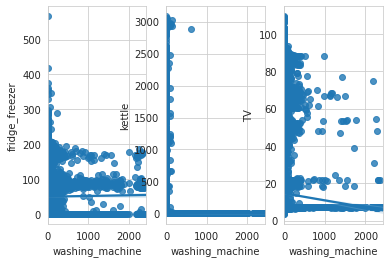

In [101]:
# Case in point with washing_machine and fridge_freezer
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=3)

sns_plot = sns.regplot(x = "washing_machine",
           y = "fridge_freezer", 
           data = df,  
           ax=axs[0])
         #  legend = True, 
         #  scatter_kws={"s": 5})


# Case in point with washing_machine and kettle
sns.set_style("whitegrid")
sns_plot = sns.regplot(x = "washing_machine",
           y = "kettle", 
           data = df,  
           ax=axs[1])
        #   legend = True, 
        #   scatter_kws={"s": 5})

# Case in point with washing_machine and TV
sns.set_style("whitegrid")
sns_plot = sns.regplot(x = "washing_machine",
           y = "TV", 
           data = df,  
           ax=axs[2])
         #  legend = True, 
         #  scatter_kws={"s": 5})

In [102]:
data["hour"].value_counts()

NameError: ignored

Measures are uniformly spread across hours, which will be useful to create two balanced datasets day/night if need be.

# Data pre-processing and Feature Engineering.

Data exploration shows us that we have weather values for every "minute 0" of each hour. So, we fill the NaNs by applying forward fill on every hour.

In [ ]:
# Printing the data for minute 0: there are nearly no missing values
data_minute_0 = df[df["minute"]==0]
print(data_minute_0.isna().sum())

We confirm that nearly all minute_0 values are reported. We fix those NaNs first: 

In [ ]:
# Identifying the NaNs we have to fix
humidity_nans = data_minute_0[data_minute_0["humidity"].isna()] # 23 observations
humidex_nans  = data_minute_0[data_minute_0["humidex"].isna()] # 23 observations
windchill_nans  = data_minute_0[data_minute_0["windchill"].isna()] # 31 observations
wind_nans  = data_minute_0[data_minute_0["wind"].isna()] # 23 observations
visibility_nans  = data_minute_0[data_minute_0["visibility"].isna()] # 23 observations
pressure_nans  = data_minute_0[data_minute_0["pressure"].isna()] # 27 observations
temperature_nans  = data_minute_0[data_minute_0["temperature"].isna()] 

# We introduce a table with the mean of each weather variable within a given month
## N.B. Mean and median are close within a given month
monthly_weather = df.groupby("month").mean().loc[:,"consumption":"pressure"].reset_index()

# We are now going to fill the nans using monthly mean for minute 0 by mapping dictionaries within a loop
weather_nans = [humidity_nans, humidex_nans, windchill_nans, wind_nans, visibility_nans, pressure_nans, temperature_nans]
weather_columns = ["humidity", "humidex", "windchill", "wind", "visibility", "pressure", "temperature"]

keys = monthly_weather["month"].tolist() # need to pass keys and values to list to make a dictionary
for i in np.arange(len(weather_nans)):
  values = monthly_weather[weather_columns[i]].tolist()
  my_dict = dict(zip(keys, values))
  weather_nans[i][weather_columns[i]] = weather_nans[i]["month"].map(my_dict)
  data_minute_0[weather_columns[i]][data_minute_0[weather_columns[i]].isna()] = weather_nans[i][weather_columns[i]]


# We must also take care of minute 1 for the first month given that there is no minute 0 
df.iloc[0,1:8] = monthly_weather.iloc[0,1:9]

df[df["minute"]==0] = data_minute_0

Let's check that we got rid of most missing values : 

In [ ]:
df[df["minute"]==0].isna().sum()

Next, we perform forward fill on the hour for all the missing weather values:

In [ ]:
# Forward fill on missing weather values
data_weather = df.loc[:,"visibility":"pressure"]
data_weather = data_weather.fillna(method='ffill')
# Replace the missing values in df
df.loc[:,"visibility":"pressure"] = data_weather

In [ ]:
df.isna().sum()

# Baseline Model training

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
selected_features = [
                     'consumption', 'visibility', 'temperature', 
                     'humidity', 'humidex','windchill', 
                     'wind', 'pressure', 'washing_machine','fridge_freezer', 'TV', 
                     'kettle', 'month', 'day', 'hour',
                     'minute','daytime', 'avg_hourly_consumption'
                     ]
final_data = df.loc[:,selected_features]
final_data.head()

In [ ]:
# Extracting a manageable subset of data
tuning_data_temp = final_data.sample(n=100000)
X = tuning_data_temp.drop(columns={"washing_machine", "kettle", "TV", "fridge_freezer", "time_step"})
y = tuning_data_temp.loc[:,"washing_machine":"kettle"]

# Training and testing
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.30)

Dummy regressor - Mean strategy

In [ ]:
dummy_reg = DummyRegressor(strategy='mean', constant=None, quantile=None)
dummy_reg.fit(X_train, y_train)

In [ ]:
# The bigger the score, the better it is (at constant #variables)
print(f"Train score : {dummy_reg.score(X_train,y_train)}")
print(f"Test score : {dummy_reg.score(X_test,y_test)}")

This is an extremely bad fit! 

Linear regression

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

In [ ]:
# The bigger the score, the better it is (at constant #variables)
print(f"Train score : {linear_reg.score(X_train,y_train)}")
print(f"Test score : {linear_reg.score(X_test,y_test)}")

 RandomForestRegressor - 100 estimators

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100,
                                   max_depth=5)
forest_reg.fit(X_train2, y_train2)

In [ ]:
# Baseline R2 on train 
print(f"Train score : {forest_reg.score(X_train, y_train)}")
print(f"Test score : {forest_reg.score(X_test, y_test)}")

Gradient boosting regressor - 100 estimators 



In [ ]:
gbm_reg = GradientBoostingRegressor(n_estimators=100)
multi_reg = MultiOutputRegressor(gbm_reg,n_jobs=-1)
multi_reg.fit(X_train,y_train)

In [ ]:
# Baseline R2 on train
print(f"Train score : {multi_reg.score(X_train, y_train)}")
print(f"Test score : {multi_reg.score(X_test, y_test)}")

Light gradient boosting regressor

In [ ]:
# Like GBM, LGBM does not support multioutput regression so we have to wrap it 
lgbm_reg = LGBMRegressor(n_estimators=100)
multi_reg2 = MultiOutputRegressor(lgbm_reg,n_jobs=-1)
multi_reg2.fit(X_train,y_train)

In [ ]:
multi_reg2.score(X_train2, y_train2)
multi_reg2.score(X_test2, y_test2)

XGBoost - 100 estimators


In [ ]:
xgb_reg = XGBRegressor()
multi_reg3 = MultiOutputRegressor(xgb_reg,n_jobs=-1)
multi_reg3.fit(X_train, y_train)

In [ ]:
print(f"Train score : {multi_reg3.score(X_train, y_train)}")
print(f"Test score : {multi_reg3.score(X_test, y_test)}")

The best model is XGBoost. Let's perform some hyperparameter tuning on a manageable dataset:

In [ ]:
# Extracting a manageable subset of data for tuning
tuning_data = final_data.sample(n=100000)
X = tuning_data.drop(columns={"washing_machine", "kettle", "TV", "fridge_freezer"})
y = tuning_data.loc[:,"washing_machine":"kettle"]

# Training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Parameter tuning using GridSearchCV : 

In [ ]:
parameters = {
    "estimator__n_estimators":[500,750,1000],
    #"estimator__learning_rate": [0.1, 0.2],
    #"estimator__max_depth":[-1,5,10],
    }

lgbm_tuned = GridSearchCV(MultiOutputRegressor(LGBMRegressor()), 
                          parameters, 
                          cv=5, 
                          n_jobs=-1,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)

t0 = time.time()
lgbm_tuned.fit(X_train, y_train).best_estimator_
print("Computing time %.2f seconds" % (time.time() - t0))

In [ ]:
lgbm_tuned.best_params_

Parameter tuning using  RandomizedSearchCV :

In [ ]:
parameters = {
    "estimator__n_estimators":[800,1000,1200],
    #"estimator__learning_rate": [0.15, 0.2],
    "estimator__max_depth":[3,5,10],
    }

reg = RandomizedSearchCV(MultiOutputRegressor(LGBMRegressor(learning_rate=0.2)), 
                   parameters, 
                   n_iter=5, 
                   scoring="neg_mean_squared_error", 
                   n_jobs=1, 
                   iid='deprecated', 
                   refit=True, 
                   cv=5, 
                   verbose=0, 
                   pre_dispatch='2*n_jobs', 
                   random_state=None, 
                   return_train_score=True)
t0 = time.time()
search = reg.fit(X_train3, y_train3)
print("Computing time %.2f seconds" % (time.time() - t0))

In [ ]:
search.best_params_

Our best model so far becomes : 

In [ ]:
best_model = MultiOutputRegressor(LGBMRegressor(n_estimators=1000, 
                                          learning_rate=0.2,
                                          max_depth=-1))
best_model.fit(X_train,y_train)

In [ ]:
print(f" Best model score on test : {best_model.score(X_train,y_train)}")
print(f" Best model score on test : {best_model.score(X_test,y_test)}")

Parameter tuning is over! Let's investigate our results on the full dataset : 

In [ ]:
X = final_data.drop(columns={"washing_machine", "kettle", "TV", "fridge_freezer"})
y = final_data.loc[:,"washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
lgbm_tuned_temp = LGBMRegressor(n_estimators=500)
best_model = MultiOutputRegressor(LGBMRegressor(n_estimators=500, 
                                          learning_rate=0.2,
                                          max_depth=5))
best_model.fit(X_train, y_train)

In [ ]:
print(f"Train score on full dataset : {best_model.score(X_train, y_train)}")
print(f"Test score on full dataset : {best_model.score(X_test, y_test)}")

Let's see what our best model scores on the custom metric:  

In [ ]:
dataframe_y_true = y_train
dataframe_y_train_pred = pd.DataFrame(best_model.predict(X_train))
dataframe_y_train_pred.columns = ["washing_machine","fridge_freezer","TV","kettle"]
print("Custom metric score on train %.2f"%metric_nilm(dataframe_y_true, dataframe_y_train_pred))

dataframe_y_true = y_test
dataframe_y_pred = pd.DataFrame(best_model.predict(X_test))
dataframe_y_pred.columns = ["washing_machine","fridge_freezer","TV","kettle"]
print("Custom metric score on test %.2f"%metric_nilm(dataframe_y_true, dataframe_y_pred))

# Final Predictions

In [ ]:
X_out = pd.read_csv(url_xout)
X_out_temp = pd.read_csv(url_xout)
X_out = initialisation(x_out)
X_out = forward_fill_consumption(x_out)
X_out = fill_weather(x_out)
X_out = add_hourly_consumption_feature(x_out, hourly_consumption_table(data, "consumption"))

In [ ]:
Y_test = create_y_predictions(x_out, best_model)